http://www.cc.gatech.edu/~mihail/D.8802readings/mcsherrystoc01.pdf 

In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
from math import floor
import random
from algorithms import NMI
from sklearn.cluster import KMeans
%matplotlib inline

eigs = sp.sparse.linalg.eigs

In [2]:
def generate_graph(n, frac, p, q, **kwargs):
    
    if ("random_state" in kwargs):
        seed = kwargs["random_state"]
        np.random.seed(seed = seed)

    s1 = int(n*frac)
    s2 = n - s1
    g_in1 = p * np.ones((s1, s1))
    g_in2 = p * np.ones((s2, s2))
    g_out1 = q * np.ones((s1, s2))
    g_out2 = q * np.ones((s2, s1))

    block_model = np.bmat([[g_in1, g_out1], [g_out2, g_in2]])
    A = 1.0 * (np.random.rand(n, n) < block_model)
    true_comm = np.concatenate([ np.ones((s1, 1)), -np.ones((s2, 1))]).T

    cluster_1 = []
    cluster_2 = []
    for arg, node in enumerate(true_comm[0]):
        if node == 1:
            cluster_1.append(arg)
        else:
            cluster_2.append(arg)
    true_comm = [cluster_1, cluster_2]
    return block_model, A, true_comm

In [3]:
def projection(matrix, x, k):
    Lambda, U = eigs(1.0 * matrix.dot(matrix.T), k, which="LR")
    Lambda, U = np.real(Lambda), np.real(U)
    if np.any(Lambda < 0):
        # From paper:  in practice some of the eigenvalues of A may
        #              be negative; if that happens, we truncate them to 0
        U, Lambda = U[:, Lambda > 0], Lambda[Lambda > 0]
        k = np.count_nonzero(Lambda > 0)
        print('Some of Lambda < 0. Now I just remove it, new k={}'.format(k))
    return np.dot(np.dot(U, U.T), x)

Description to $\textbf{def cproj(matrix, x)}$

not clear instructions are defined in article on website:  http://www.cc.gatech.edu/~mihail/D.8802readings/mcsherrystoc01.pdf (3.2 par)

In [4]:
seed = 0

In [5]:
def cproj(matrix, s_m=5, tau=1.5, k=2):

    A = matrix.T
    n_nodes = A.shape[1]
    unclassified_nodes = set(np.arange(n_nodes))
    T = []

    while len(unclassified_nodes) > s_m/2:
        v_i = np.random.choice(list(unclassified_nodes))
        T_i = []
        T_i.append(v_i)
        unclassified_nodes.remove(v_i)
        subtraction_matrix = A[:,v_i].reshape((A.shape[0],1)) - A
        multiplication_matrix = projection(matrix = A, x = subtraction_matrix, k=k)
        norms = np.linalg.norm(multiplication_matrix, axis=0)

        for u in range(n_nodes):
            if (u in unclassified_nodes) and (norms[u] <= tau):
                T_i.append(u)
                unclassified_nodes.remove(u)
        T.append(T_i)

    INF = float("INF")
    for u in unclassified_nodes:
        min_distance = INF
        tmp_u = 0
        for (T_i, i) in zip(T, range(len(T))):
            norm = np.linalg.norm(projection(matrix = A, x = A[:,T_i[0]] - A[:,u], k=k))
            if  norm < min_distance:
                min_distance = norm
                tmp_u = i
        T[tmp_u].append(u)

    C = []
    for T_i in T:
        C_i = np.arange(0, n_nodes)
        for node in range(n_nodes):
            if node in set(T_i):
                C_i[node] = 1
            else:
                C_i[node] = 0
        C.append(C_i)
    C = np.matrix(C)
    return C.T

In [6]:
def Clustering(graph, tau=1.5, k=2):

    if type(graph) == nx.classes.graph.Graph:
        hat_G = nx.adjacency_matrix(G = graph).toarray()
        n_nodes = hat_G.shape[0]
    else:
        hat_G = graph
        n_nodes = graph.shape[0]

    s_m = n_nodes/2
    permutation = np.random.permutation(n_nodes)
    first_part_of_nodes = permutation[: int(n_nodes/2)]
    second_part_of_nodes = permutation[int(n_nodes/2) :]

    A = hat_G[:,first_part_of_nodes]
    B = hat_G[:,second_part_of_nodes]

    P1 = projection(matrix=cproj(B, s_m=s_m, tau=tau), x=A, k=k)
    P2 = projection(matrix=cproj(A, s_m=s_m, tau=tau), x=B, k=k)
    hat_H = np.hstack((P1, P2))
    hat_H = np.zeros_like(hat_H)
    hat_H[:, first_part_of_nodes] = P1
    hat_H[:, second_part_of_nodes] = P2

    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=1231)
    ans = np.array(kmeans.fit_predict(hat_H))

    T = []
    for i in range(ans.min(), ans.max()+1):
        T_i = []
        for ind, j in enumerate(ans):
            if j==i:
                T_i.append(ind)
        T.append(T_i)
    return T

In [7]:
def clustering_result(n=500, k=2, p=0.6, q=0.3, frac=0.5, tau = 0.1, n_iter=3):
    score = []
    for i in range(n_iter):
        block_model, A, true_comm = generate_graph(n=n, frac=frac, p=p, q=q)
        ans = Clustering(A, tau, k)
        score.append(NMI.NMI(ans, true_comm))
    return (np.array(score).mean(), np.array(score).std())

In [8]:
%%time
_, A, true_comm = generate_graph(n=400, frac=0.5, p=0.3, q=0.1)
ans = Clustering(A, tau=2, k=2)
print(NMI.NMI(ans, true_comm))

0.977275
CPU times: user 284 ms, sys: 29.9 ms, total: 314 ms
Wall time: 246 ms


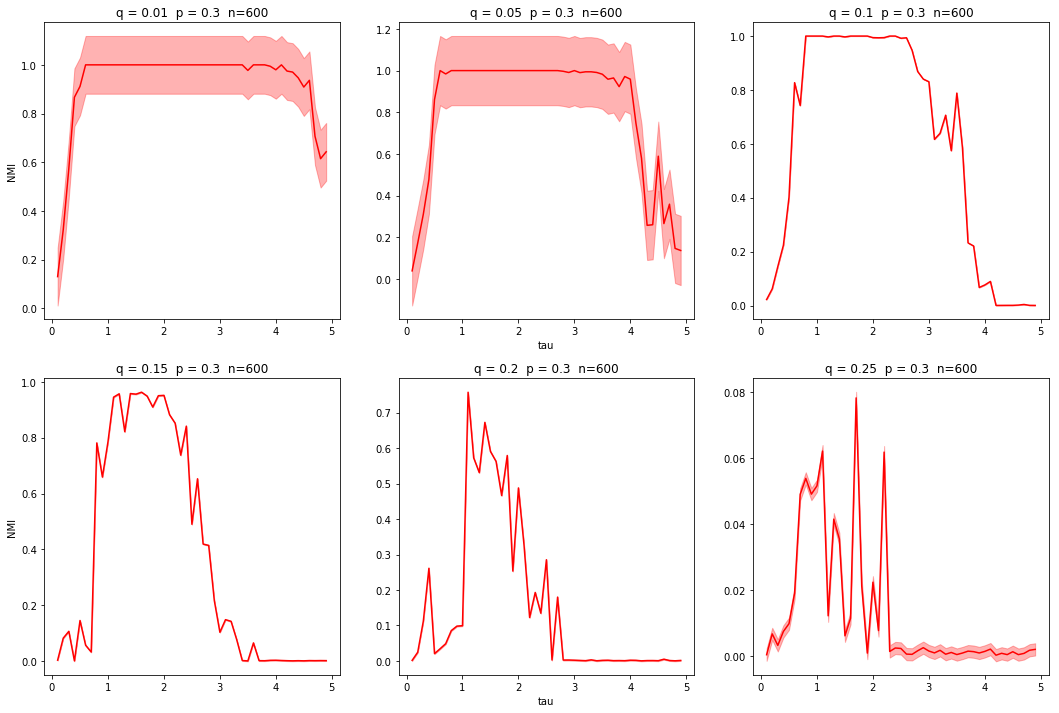

In [11]:
P = 0.3
qarr = [[0.01, 0.05, 0.1], [0.15, 0.2, 0.25]]
tau_arr = np.arange(0.1, 5,  0.1)
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(18)

nmi =[]
std = []

for arr_q, arr_x in zip(qarr, axarr):
    for q, ax in zip(arr_q, arr_x):
        nmi = []
        diff = []
        std = []
        for tau in tau_arr:
            score, std = clustering_result(n=600, k=2, p=P, q=q, frac=0.5, tau = tau, n_iter=5)
            nmi.append(score)
        ax.plot(tau_arr, nmi, color = "r")
        ax.fill_between(tau_arr, np.array(nmi)+np.array(std), np.array(nmi)-np.array(std), color="r", alpha=0.3)
        ax.set_title("q = {0}  p = {1}  n=600".format(q, P))
        
axarr[0][0].set_ylabel(ylabel = "NMI")
axarr[1][0].set_ylabel(ylabel = "NMI")
axarr[0][1].set_xlabel(xlabel = "tau")
axarr[1][1].set_xlabel(xlabel = "tau")

50
100
500
1000
2000
5000


KeyboardInterrupt: 

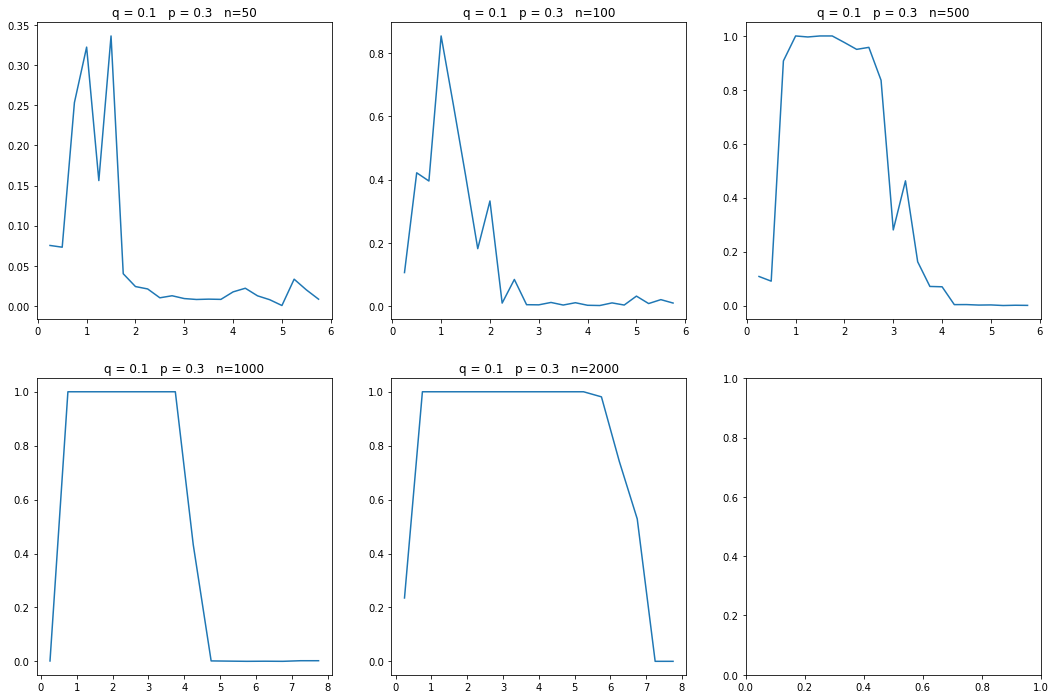

In [12]:
P = 0.3
Q = 0.1
narr = [[50, 100, 500], [1000, 2000, 5000]]
tau_arr = np.arange(0.25, 6,  0.25)
fig, axarr = plt.subplots(2, 3)
fig.set_figheight(12)
fig.set_figwidth(18)

nmi =[]
std = []

for arr_n, arr_x in zip(narr, axarr):
    for n, ax in zip(arr_n, arr_x):
        print(n)
        if n < 1000:
            n_iter = 5
            tau_arr = np.arange(0.25, 6,  0.25)
        else:
            n_iter = 1
            tau_arr = np.arange(0.25, 8,  0.5)
        nmi = []
        diff = []
        std = []
        for tau in tau_arr:
            score, _ = clustering_result(n=n, k=2, p=P, q=Q, frac=0.5, tau = tau, n_iter=n_iter)
            nmi.append(score)
        ax.plot(tau_arr, nmi)
        ax.set_title("q = {0}   p = {1}   n={2}".format(Q, P, n))
        
axarr[0][0].set_ylabel(ylabel = "NMI")
axarr[1][0].set_ylabel(ylabel = "NMI")
axarr[0][1].set_xlabel(xlabel = "tau")
axarr[1][1].set_xlabel(xlabel = "tau")